In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats import diagnostic as sms
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from itertools import zip_longest as lzip
import missingno as msno
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [2]:
#file1 = '/Users/Павел/Documents/Курсовой проект/XLS/Countries.csv'
file1 = '/Users/Administrator/Documents/GitHub/Data-Analyst-Project/XLS/Countries.csv'
df = pd.read_csv(file1,
     dtype={'Year': 'int16', 
            'Total_weight_kg': 'float32', 
            'lines': 'float32', 
            'stations': 'float32', 
            'annual_ridership_mill': 'float32',
            'Population_eating_chocolate': 'float32',
            'GDP_USD': 'float32',
            'Inflation': 'float32',
            'kg_per_person': 'float32',
            'kg_per_GDP': 'float32'})

# Проверка миссингов
msno.bar(df);

df.columns

df.dtypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      3159 non-null   object 
 1   Year                         3159 non-null   int16  
 2   Total_weight_kg              3157 non-null   float32
 3   availability_of_metro        3159 non-null   object 
 4   lines                        928 non-null    float32
 5   stations                     928 non-null    float32
 6   annual_ridership_mill        928 non-null    float32
 7   Population_eating_chocolate  3159 non-null   float32
 8   GDP_USD                      3112 non-null   float32
 9   Inflation                    2509 non-null   float32
 10  kg_per_person                3157 non-null   float32
 11  kg_per_GDP                   3110 non-null   float32
dtypes: float32(9), int16(1), object(2)
memory usage: 166.7+ KB


In [4]:
# 1 ЭТАП
# Заполнение миссингов
# 1.1 Вычисляем средние значения по странам
country_means = df.groupby('Country')['Total_weight_kg'].transform('mean')
df['Total_weight_kg'] = df['Total_weight_kg'].mask((df['Total_weight_kg'].isna()) | (df['Total_weight_kg'] == 0), country_means)
# 1.2 Вычисляем среднее значение Inflation по каждому году
inflation_means_by_year = df.groupby('Year')['Inflation'].transform('mean')
# Заменяем пропуски в 'Inflation' на средние значения по году
df['Inflation'] = df['Inflation'].fillna(inflation_means_by_year)
# 1.3 Заполнение пропусков GDP_USD
replacement_GDP = {
    'Faroe Islands': ('Denmark', 0.015),
    'Mayotte': ('Comoros', 2),
    'Netherlands Antilles': ('Netherlands', 0.005),
    'Sudan': ('Egypt', 0.3),
    'Wallis and Futuna Islands': ('New Zealand', 0.001)}
# Обрабатываем каждое правило
for country, (source_country, multiplier) in replacement_GDP.items():
    # Находим строки с пропусками GDP_USD для текущей страны
    missing_mask = (df['Country'] == country) & (df['GDP_USD'].isna())
    # Для каждой строки с пропуском находим соответствующее значение из страны-источника по году
    for idx in df[missing_mask].index:
        year = df.at[idx, 'Year']
        # Ищем GDP_USD для страны-источника в том же году
        source_gdp = df.loc[(df['Country'] == source_country) & (df['Year'] == year), 'GDP_USD'].values
        if len(source_gdp) > 0:  # Если значение найдено
            calculated_value = np.float32(source_gdp[0] * multiplier)
            df.at[idx, 'GDP_USD'] = calculated_value
# 1.4 Заполнение пропусков в kg_per_person: total_weight_kg / Population_eating_chocolate
mask_kg_per_person = df['kg_per_person'].isna()
df.loc[mask_kg_per_person, 'kg_per_person'] = (
    df.loc[mask_kg_per_person, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_person, 'Population_eating_chocolate']).astype('float32')
# 1.5 Заполнение пропусков в kg_per_GDP: total_weight_kg / GDP_USD
mask_kg_per_gdp = df['kg_per_GDP'].isna()
df.loc[mask_kg_per_gdp, 'kg_per_GDP'] = (
    df.loc[mask_kg_per_gdp, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_gdp, 'GDP_USD']).astype('float32')

In [5]:
df.isna().sum()

Country                           0
Year                              0
Total_weight_kg                   0
availability_of_metro             0
lines                          2231
stations                       2231
annual_ridership_mill          2231
Population_eating_chocolate       0
GDP_USD                           0
Inflation                         0
kg_per_person                     0
kg_per_GDP                        0
dtype: int64

In [6]:
# Сохранение результата
output_file = "Results_df.csv"
df.to_csv(output_file, index=False)

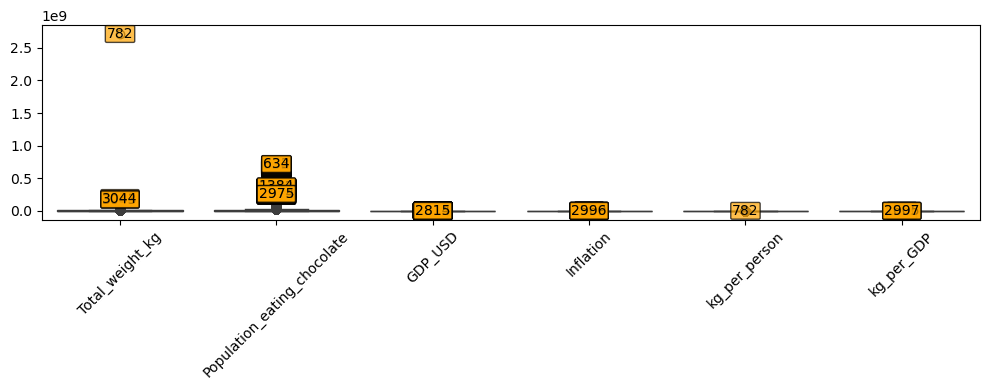

In [7]:
# 2 ЭТАП
# 2.1 Проверка и удаление выбросов по столбцам
numeric_cols = ['Total_weight_kg', 'Population_eating_chocolate', 'GDP_USD', 'Inflation', 'kg_per_person', 'kg_per_GDP']
plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
# Функция для поиска выбросов методом z-score
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
# Добавляем аннотации с номерами строк для выбросов
for column in numeric_cols:
    # Находим выбросы для текущего столбца
    outliers_idx = find_outliers_zscore(df, column, threshold=3)
    # Получаем позицию столбца на графике
    col_pos = numeric_cols.index(column)
    # Добавляем аннотации
    for idx in outliers_idx:
        value = df.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [8]:
# 2.1 Удаление строк с выбросами по столбцу 'Total_weight_kg'
outliers_indices = find_outliers_zscore(df, 'Total_weight_kg', threshold=4)
print(f"Найдено выбросов в 'Total_weight_kg': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
# Полное удаление строки с выбросом
dfW = df.drop(index=outliers_indices).copy()

Найдено выбросов в 'Total_weight_kg': 1
Индексы строк с выбросами: [782]


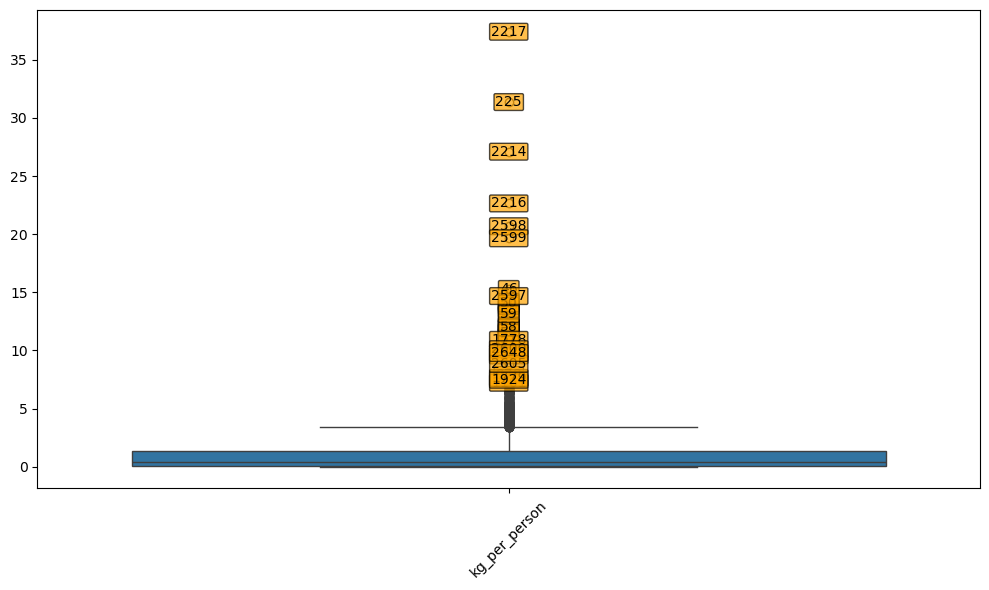

In [9]:
# 2.2 Проверка и удаление выбросов по столбцу 'kg_per_person'
numeric_cols = ['kg_per_person']
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=dfW[numeric_cols])
plt.xticks(rotation=45)
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
for column in numeric_cols:
    outliers_idx = find_outliers_zscore(dfW, column, threshold=3)
    col_pos = numeric_cols.index(column)
    for idx in outliers_idx:
        value = dfW.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [10]:
# 2.2 Количество строк с выбросами по столбцу 'kg_per_person'
outliers_indices = find_outliers_zscore(dfW, 'kg_per_person', threshold=2)
print(f"Найдено выбросов в 'kg_per_person': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
# Полное удаление строки с выбросом
dfW1 = dfW.drop(index=outliers_indices).copy()

Найдено выбросов в 'kg_per_person': 97
Индексы строк с выбросами: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 225, 247, 304, 342, 343, 344, 345, 346, 785, 978, 1024, 1025, 1026, 1027, 1089, 1091, 1092, 1093, 1095, 1096, 1098, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1226, 1227, 1228, 1229, 1230, 1416, 1579, 1683, 1686, 1687, 1688, 1689, 1692, 1778, 1779, 1780, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 2208, 2209, 2214, 2215, 2216, 2217, 2524, 2597, 2598, 2599, 2600, 2605, 2645, 2647, 2648, 2649, 2650, 2895]


In [11]:
dfW1[39:44]

,Country,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,GDP_USD,Inflation,kg_per_person,kg_per_GDP
39,Algeria,2014,16965132.0,Yes,1.0,19.0,2.4,13721761.0,5453.640137,2.916927,1.24,3110.790039
40,Algeria,2015,10983088.0,Yes,1.0,19.0,2.4,14006835.0,4147.450195,4.784447,0.78,2648.149902
41,Algeria,2016,10542453.0,Yes,1.0,19.0,2.4,14297752.0,3917.540039,6.397695,0.74,2691.090088
60,Angola,2007,3654953.0,No,NaN,NaN,NaN,6441354.0,3141.050049,12.251497,0.57,1163.609985
61,Angola,2009,1693669.0,No,NaN,NaN,NaN,6948580.0,3136.649902,13.730284,0.24,539.960022


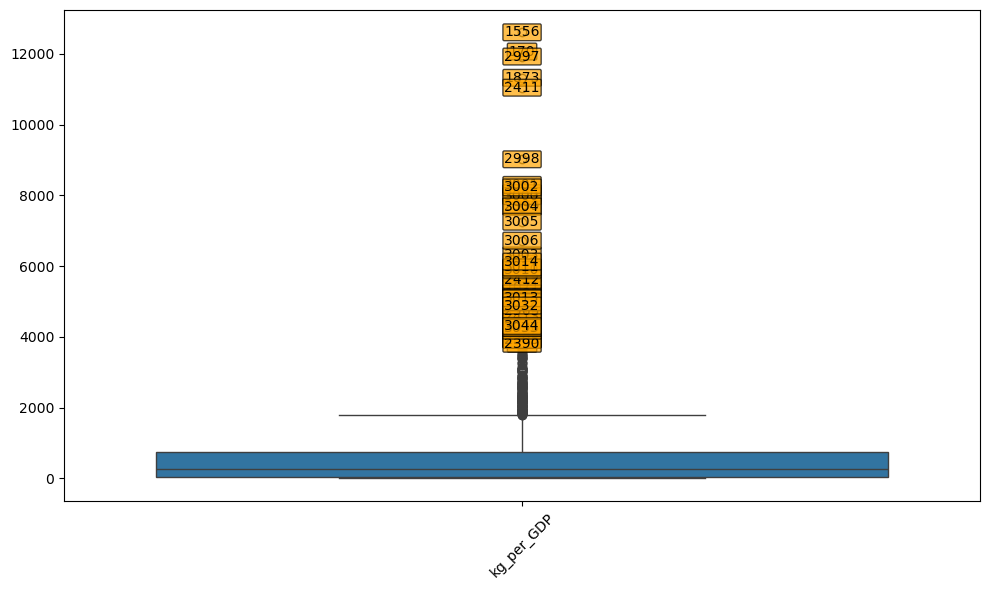

In [12]:
# 2.3 Повторная проверка и удаление выбросов
numeric_cols = ['kg_per_GDP']
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=dfW1[numeric_cols])
plt.xticks(rotation=45)
# Функция для поиска выбросов методом z-score
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
# Добавляем аннотации с номерами строк для выбросов
for column in numeric_cols:
    # Находим выбросы для текущего столбца
    outliers_idx = find_outliers_zscore(dfW1, column, threshold=3)
    # Получаем позицию столбца на графике
    col_pos = numeric_cols.index(column)
    # Добавляем аннотации
    for idx in outliers_idx:
        value = dfW1.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [13]:
# 2.3 Количество строк с выбросами
outliers_indices = find_outliers_zscore(dfW1, 'kg_per_GDP', threshold=2)
print(f"Найдено выбросов в 'kg_per_GDP': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
# Полное удаление строки с выбросом
dfW2 = dfW1.drop(index=outliers_indices).copy()

Найдено выбросов в 'kg_per_GDP': 119
Индексы строк с выбросами: [34, 35, 36, 38, 39, 170, 360, 376, 377, 378, 379, 618, 619, 620, 621, 622, 633, 823, 916, 922, 986, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1085, 1086, 1159, 1381, 1382, 1383, 1534, 1535, 1537, 1538, 1556, 1583, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1865, 1866, 1868, 1872, 1873, 1902, 1903, 1904, 2302, 2303, 2304, 2305, 2306, 2307, 2309, 2310, 2318, 2336, 2337, 2338, 2339, 2390, 2391, 2409, 2410, 2411, 2412, 2413, 2415, 2416, 2417, 2562, 2563, 2565, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3030, 3032, 3033, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3117, 3118]


In [14]:
dfW2

,Country,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,GDP_USD,Inflation,kg_per_person,kg_per_GDP
0,Albania,1996,273411.0,No,NaN,NaN,NaN,1557925.0,985.820007,12.725478,0.18,277.339996
1,Albania,1997,222897.0,No,NaN,NaN,NaN,1550237.0,688.820007,33.180275,0.14,323.589996
2,Albania,1998,243309.0,No,NaN,NaN,NaN,1540864.0,795.880005,20.642859,0.16,305.709991
3,Albania,1999,420293.0,No,NaN,NaN,NaN,1530526.0,1010.369995,0.389438,0.27,415.980011
4,Albania,2000,303615.0,No,NaN,NaN,NaN,1519751.0,1101.520020,0.050018,0.20,275.630005
...,...,...,...,...,...,...,...,...,...,...,...,...
3154,Zimbabwe,2012,629857.0,No,NaN,NaN,NaN,4559903.0,1238.599976,3.725327,0.14,508.519989
3155,Zimbabwe,2013,556758.0,No,NaN,NaN,NaN,4624557.0,1362.300049,1.634950,0.12,408.690002
3156,Zimbabwe,2014,576602.0,No,NaN,NaN,NaN,4688428.0,1372.209961,-0.197785,0.12,420.200012
3157,Zimbabwe,2015,486762.0,No,NaN,NaN,NaN,4751674.0,1386.420044,-2.430969,0.10,351.089996


In [15]:
# Сохранение результата
output_file = "Results_dfW2.csv"
dfW2.to_csv(output_file, index=False)

In [16]:
# 3 ЭТАП
# Формируем нулевую гипотезу (H0): В странах с метро уровень потребления шоколада среди населения такой же как и без метро.
# Формируем альернативную гипотезу (H1): В странах с метро уровень потребления шоколада среди населения выше чем без метро.
# 3.1 Сравнение средних 'Total_weight_kg' между группами с метро
with_metro = dfW2[dfW2['availability_of_metro'] == "Yes"]['Total_weight_kg']
without_metro = dfW2[dfW2['availability_of_metro'] == "No"]['Total_weight_kg']
t_statistic, p_value = stats.ttest_ind(with_metro, without_metro)
f"results_ttest: T-статистика: {t_statistic:.4f}, P-значение: {p_value:.4f}"

'results_ttest: T-статистика: 26.9145, P-значение: 0.0000'

Высокая T-статистика (25.73)
Это означает, что разница в средних значениях между группами очень большая (чем выше |T|, тем значимее разница).
P-значение ≈ 0.0000 (p < 0.05) Поскольку p-value < 0.05 (и даже < 0.001), мы отвергаем H0 и подтверждаем H1.
Вывод: Разница в потреблении шоколада между городами с метро и без метро статистически значима.

print("Среднее потребление с метро:", with_metro.mean())
print("Среднее потребление без метро:", without_metro.mean())

In [17]:
# 4 ЭТАП
# РЕГРЕСИОННЫЙ АНАЛИЗ
# Принимаем outcome - kg_per_person; predictors - availability_of_metro, Population_eating_chocolate, GDP_USD, Inflation, annual_ridership_mill, lines

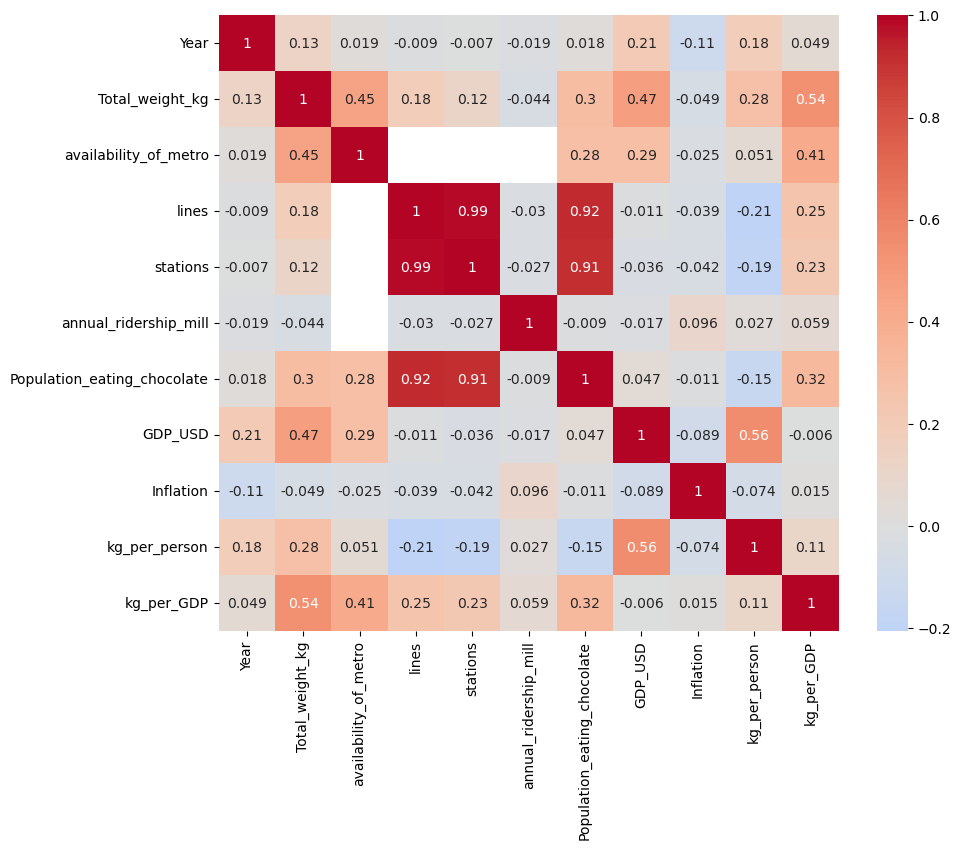

In [18]:
# 4.1 Подготовка данных - преобразуем категориальные переменные в числовые
dfK1 = dfW2[['Year', 'Total_weight_kg', 'availability_of_metro', 'lines', 'stations', 'annual_ridership_mill','Population_eating_chocolate', 'GDP_USD','Inflation','kg_per_person','kg_per_GDP']].copy()
dfK1['availability_of_metro'] = dfK1['availability_of_metro'].map({'Yes': 1, 'No': 0})
# 4.2 Корреляционный анализ
correlation_matrix = dfK1.corr().round(3)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

# Выводим таблицу корреляций
print(correlation_matrix)

Целевая переменная (kg_per_person):
Наибольшая корреляция с GDP_USD (0.391) - положительная связь
Слабая отрицательная связь с Population_eating_chocolate (-0.111) и lines (-0.138)
Практически нулевая связь с наличием метро (-0.019)
Проблемы мультиколлинеарности:
Очень высокая корреляция между:
Population_eating_chocolate и lines (0.929)
availability_of_metro и Population_eating_chocolate (0.297)
Это может исказить оценки модели

In [19]:
# 4.3 Модель с логарифмированным GDP без мультиколлинеарных и слабокоррелирующих предикторов (без Population_eating_chocolate, lines, annual_ridership_mill, Inflation)
dfK1['log_GDP'] = np.log(dfK1['GDP_USD'])
dfK1['log_GDP'] = np.log(dfK1['GDP_USD'])
model = smf.ols('kg_per_person ~ availability_of_metro + log_GDP', data=dfK1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          kg_per_person   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     789.8
Date:                Wed, 16 Jul 2025   Prob (F-statistic):          3.17e-275
Time:                        11:57:53   Log-Likelihood:                -3880.6
No. Observations:                2942   AIC:                             7767.
Df Residuals:                    2939   BIC:                             7785.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.8533      0.095    -30.111      0.000      -3.039      -2.668
availability_of_metro    -0.4372      0.040    -10.989      0.000      -0.515      -0.359
log_GDP                   0.4542      0.011     39.596      0.000       0.432       0.477
==============================================================================
Omnibus:                      849.628   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2461.465
Skew:                           1.497   Prob(JB):                         0.00
Kurtosis:                       6.334   Cond. No.                         49.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# 4.4 Проверка нормальности распределения
print("\nПроверка нормальности распределения зависимой переменной:")
shapiro_test = stats.shapiro(dfK1['kg_per_person'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')


Проверка нормальности распределения зависимой переменной:
Shapiro-Wilk Test Statistic: 0.7395
p-value: 0.0000000000



Анализ распределения:


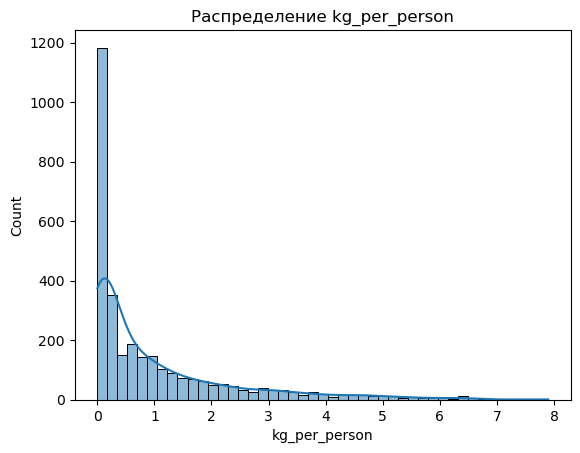

Коэффициент асимметрии: 1.9331941604614258


In [21]:
# 4.5 Визуализация распределения и асимметрии
print("\nАнализ распределения:")
sns.histplot(data=dfK1, x="kg_per_person", kde=True)
plt.title('Распределение kg_per_person')
plt.show()
skewness = dfK1['kg_per_person'].skew()
print(f'Коэффициент асимметрии: {skewness}')

Тест Шапиро-Уилка:
Статистика = 0.7395 (чем ближе к 1, тем ближе к нормальности).
p-value = 0.0000 → распределение крайне ненормальное (p < 0.05 отвергает гипотезу о нормальности).
Исходные данные kg_per_person имеют сильно скошенное распределение (возможно, с выбросами или экспоненциальный рост). Это делает некорректным использование методов, предполагающих нормальность (линейная регрессия OLS).

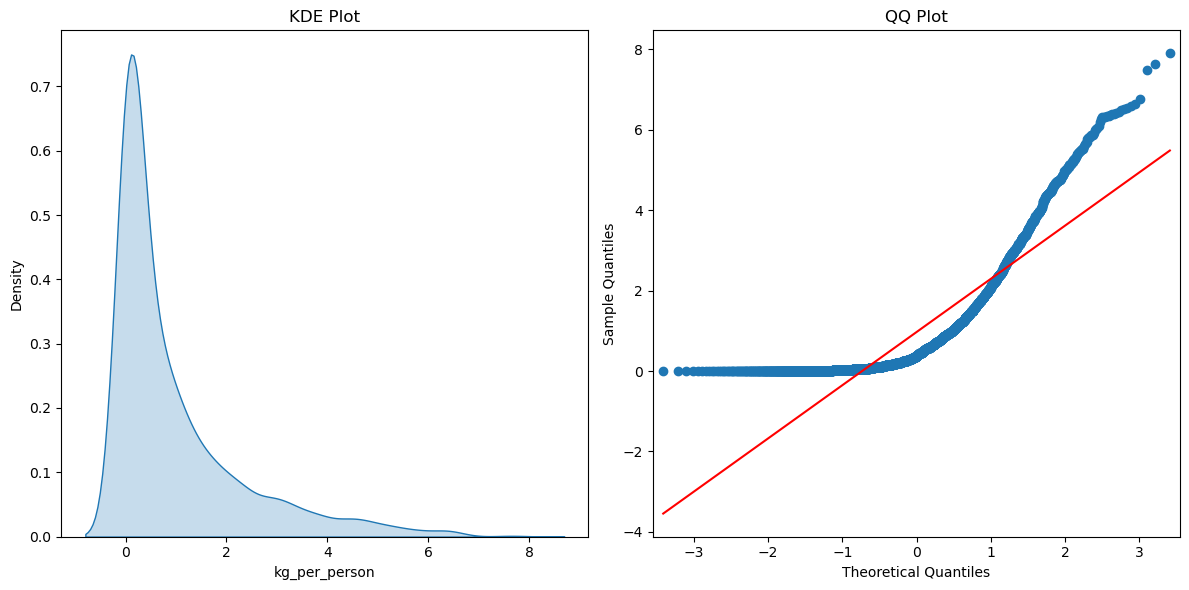

In [22]:
# 5 ЭТАП
# ДИСПЕРСИОННЫЙ АНАЛИЗ
# Визуализация распределения kg_per_person с использванием KDE Plot и QQ-Plot
# ВООБЩЕ НЕ Наблюдается приблизительно нормальное распределение kg_per_person по KDE Plot и QQ-Plot, т.е. ВООБЩЕ НЕЛЬЗЯ можно использовать ANOVA как относительно робастный метод
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(dfW2['kg_per_person'], fill=True)
plt.title('KDE Plot')
          
plt.subplot(1, 2, 2)
sm.qqplot(dfW2['kg_per_person'], line='s', ax=plt.gca())
plt.title('QQ Plot')
plt.tight_layout()

In [26]:
import statsmodels.formula.api as smf
model = smf.rlm('kg_per_person ~ availability_of_metro + log_GDP', 
                data=dfK1, 
                M=sm.robust.norms.HuberT()).fit()
print(model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          kg_per_person   No. Observations:                 3094
Model:                            RLM   Df Residuals:                     3091
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 16 Jul 2025                                         
Time:                        11:17:49                                         
No. Iterations:                    48                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.51

In [27]:
model1 = smf.glm('kg_per_person ~ availability_of_metro + log_GDP', 
               data=dfK1, 
               family=sm.families.Gamma()).fit()
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          kg_per_person   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3091
Model Family:                   Gamma   Df Model:                            2
Link Function:           InversePower   Scale:                          2.6079
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Wed, 16 Jul 2025   Deviance:                       24611.
Time:                        11:20:12   Pearson chi2:                 8.06e+03
No. Iterations:                     9   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.50

C:\Users\Administrator\AppData\Local\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\Administrator\AppData\Local\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
C:\Users\Administrator\AppData\Local\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1891: RuntimeWarning: invalid value encountered in scalar subtract
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


# Для проверки гипотезы о том, что наличие метро в стране влияет на уровень потребления шоколада, применим непараметрический тест Манна-Уитни, так как распределение данных (kg_per_person) крайне ненормальное (как показал предыдущий анализ с коэффициентом асимметрии = 1.93).
# 1. Подготовка данных
# Разделяем данные на две группы:
with_metro = dfW2[dfW2['availability_of_metro'] == 'Yes']['kg_per_person'].dropna()
without_metro = dfW2[dfW2['availability_of_metro'] == 'No']['kg_per_person'].dropna()

# 2. Описательная статистика
print("Описательная статистика:")
print(f"Страны с метро (n={len(with_metro)}):")
print(f"Медиана: {np.median(with_metro):.2f} кг/чел")
print(f"Страны без метро (n={len(without_metro)}):")
print(f"Медиана: {np.median(without_metro):.2f} кг/чел")

# 3. Визуализация
plt.figure(figsize=(8, 10))
sns.boxplot(x='availability_of_metro', y='kg_per_person', data=dfW2)
plt.title('Потребление шоколада в странах с метро и без')
plt.xlabel('Наличие метро')
plt.ylabel('кг/человека')
plt.show()

# 4. Тест Манна-Уитни
stat, p = mannwhitneyu(with_metro, without_metro, alternative='greater')  # Односторонний тест (H1: with_metro > without_metro)

print("\nРезультаты теста Манна-Уитни:")
print(f"Статистика: {stat:.2f}")
print(f"p-value: {p:.5f}")

# 5. Интерпретация
alpha = 0.05
if p < alpha:
    print("\nВывод: Отвергаем нулевую гипотезу. Потребление шоколада значимо выше в странах с метро (p < 0.05).")
else:
    print("\nВывод: Нет оснований отвергать нулевую гипотезу. Потребление шоколада не отличается значимо.")

plt.figure(figsize=(10, 6))
sns.violinplot(x='availability_of_metro', y='kg_per_person', data=dfW2, cut=0)
plt.title('Распределение потребления шоколада')
plt.xlabel('Наличие метро')
plt.ylabel('кг/человека')
plt.show()

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 7. Проверка мультиколлинеарности (VIF)
print("\nПроверка мультиколлинеарности:")
X = model.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [VIF(X, i) for i in range(X.shape[1])]
print(vif_data)

# 8. Проверка автокорреляции (Дарбин-Уотсон)
print("\nТест Дарбина-Уотсона:")
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")

# 9. Проверка гетероскедастичности (Бреуш-Паган)
print("\nТест Бреуша-Пагана на гетероскедастичность:")
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = het_breuschpagan(model.resid, model.model.exog)
print(list(zip(name, test)))

# 10. Анализ выбросов (леверидж)
print("\nАнализ выбросов:")
fig, ax = plt.subplots(figsize=(12, 12))
sm.graphics.plot_leverage_resid2(model, ax=ax)
plt.show()

# # 11. Робастная регрессия (если есть выбросы)
# print("\nРобастная регрессия:")
# robust_model = sm.RLM(dfW2['kg_per_person'], 
#                      sm.add_constant(dfW2[['availability_of_metro', 'GDP_USD']]),
#                      M=sm.robust.norms.HuberT()).fit()
# print(robust_model.summary())

# # 12. Визуализация всех переменных
# print("\nДиаграммы размаха для всех переменных:")
# plt.figure(figsize=(12, 8))
# plt.boxplot([dfW2['kg_per_person'], dfW2['GDP_USD']], 
#            labels=['kg_per_person', 'GDP_USD'])
# plt.title('Диаграммы размаха для переменных')
# plt.ylabel('Значения')
# plt.grid(True)
# plt.show()

# # 13. Центрирование переменных (дополнительно)
# print("\nМодель с центрированными переменными:")
# df_centered = dfW2.copy()
# cols_to_center = ['GDP_USD']
# df_centered[cols_to_center] = dfW2[cols_to_center] - dfW2[cols_to_center].mean()
# centered_model = smf.ols('kg_per_person ~ availability_of_metro + GDP_USD', 
#                         data=df_centered).fit()
# print(centered_model.summary())

df.columns

unique_count = df.Year.nunique()
unique_count

#SELECT sql FROM sqlite_master WHERE type = 'view';